In [1]:
!pip install git+https://github.com/qubvel/classification_models.git




import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import cv2
import tensorflow as tf

from math import ceil, floor
from copy import deepcopy
from tqdm.notebook import tqdm
from imgaug import augmenters as iaa

import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Recall, Precision, BinaryCrossentropy
from classification_models.tfkeras import Classifiers
from tensorflow.keras.layers import *
from sklearn.utils.class_weight import compute_class_weight

def calculating_class_weights(y_true):
    number_dim = np.shape(y_true)[1]
    weights = np.empty([number_dim, 2])
    for i in range(number_dim):
        weights[i] = compute_class_weight('balanced', classes=np.unique(y_true[:, i]), y=y_true[:, i])
    return weights


def ModelCheckpointFull(model_name):
    return ModelCheckpoint(model_name, 
                            monitor = 'val_accuracy', 
                            verbose = 1, 
                            save_best_only = True, 
                            save_weights_only = True, 
                            mode = 'max', 
                            period = 1)

# Create Model
def create_model(num_classes):
    K.clear_session()
    
#     SE_resnext101, preprocess_input = Classifiers.get('seresnext101')
#     engine = SE_resnext101(include_top=False,
#                            input_shape=(256, 256, 3),
#                            backend = tf.keras.backend,
#                            layers = tf.keras.layers,
#                            models = tf.keras.models,
#                            utils = tf.keras.utils,
#                           weights = 'imagenet')
## resNet18
    mobileNet, preprocess_input = Classifiers.get('resnet18')
    engine = mobileNet(include_top=False,
                           input_shape=(256, 256, 3),
                           backend = tf.keras.backend,
                           layers = tf.keras.layers,
                           models = tf.keras.models,
                           utils = tf.keras.utils,
                          weights = 'imagenet')
##
    x = GlobalAveragePooling2D(name='avg_pool')(engine.output)
    x = Dropout(0.15)(x)
    out = Dense(num_classes, activation='sigmoid', name='new_output')(x)
    model = Model(inputs=engine.input, outputs=out)

    return model

def metrics_define(num_classes):
    metrics_all = ['accuracy',
    AUC(curve='PR',multi_label=True,name='auc_pr'),
    AUC(multi_label=True, name='auc_roc')
    ]

    return metrics_all

def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-xzyns_pn
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-xzyns_pn
  Resolved https://github.com/qubvel/classification_models.git to commit a0f006e05485a34ccf871c421279864b0ccd220b
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 2.6 MB/s 
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20045 sha256=f36230a4bda6793207416d3e89a1479dea79822e894d1ff1a41619a33e68d592
  Stored in directory: /tmp/pip-ephem-wheel-cache-4c216vnp/wheels/0b/96/56/27b17c903efc647c51e4f364bfc20aa67f8d3dccad63c4fb4e
Successfully built image-classifiers


In [2]:
import pydicom

def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):    
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img = cv2.resize(img, SHAPE[:2], interpolation = cv2.INTER_LINEAR)
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = window_image(dcm, 40, 380)
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)
    return bsb_img

def _read_dicom(path, SHAPE):
    dcm = pydicom.dcmread(path)
    try:
        img = bsb_window(dcm)
    except:
        img = np.zeros(SHAPE)
    return img

In [3]:
def _read_png(path, SHAPE):
    img = cv2.imread(path)
    img = cv2.resize(img, dsize=(256, 256))
    return img/255.0

# Image Augmentation
sometimes = lambda aug: iaa.Sometimes(0.25, aug)
augmentation = iaa.Sequential([ iaa.Fliplr(0.25),
                                iaa.Flipud(0.10),
                                sometimes(iaa.Crop(px=(0, 25), keep_size = True, sample_independently = False))   
                            ], random_order = True)       
        
# Generators
class TrainDataGenerator(keras.utils.Sequence):
    def __init__(self, dataset, class_names, batch_size = 16, img_size = (256, 256, 3), 
                 augment = False, shuffle = True, *args, **kwargs):
        self.dataset = dataset
        self.ids = self.dataset['imgfile'].values
        self.labels = self.dataset[class_names].values
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(ceil(len(self.ids) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X, Y = self.__data_generation(indices)
        return X, Y

    def augmentor(self, image):
        augment_img = augmentation        
        image_aug = augment_img.augment_image(image)
        return image_aug

    def on_epoch_end(self):
        self.indices = np.arange(len(self.ids))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, indices):
        X = np.empty((self.batch_size, *self.img_size))
        Y = np.empty((self.batch_size, len(class_names)), dtype=np.float32)
        
        for i, index in enumerate(indices):
            ID = self.ids[index]
            if '.png' not in ID:
                image = _read_dicom('../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train/'+ID+'.dcm', self.img_size)
            else:
                if 'NonHemo' in ID:
                    image = _read_png('../input/cq500-normal-images-and-labels/'+ID, self.img_size)
                else:
                    if 'content' in ID:
                        ID = ID[9:]
                    image = _read_png('../input/rsna-cq500-abnormal-data/'+ID, self.img_size)
            if self.augment:
                X[i,] = self.augmentor(image)
            else:
                X[i,] = image
            Y[i,] = self.labels[index]        
        return X, Y

In [4]:
from prettytable import PrettyTable
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns


def print_confusion_matrix(y_test, y_pred, class_names):
    matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    cm = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm,cmap='crest',linecolor='white',linewidths=1,annot=True, xticklabels = class_names, yticklabels = class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def print_performance_metrics(y_test, y_pred, class_names):
    print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
    print('Precision:', np.round(metrics.precision_score(y_test, y_pred, average='weighted'),4))
    print('Recall:', np.round(metrics.recall_score(y_test, y_pred, average='weighted'),4))
    print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred, average='weighted'),4))
    print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred), 4))
    print('Matthews Corrcoef:', np.round(metrics.matthews_corrcoef(y_test, y_pred), 4))
    if len(np.unique(y_test)) == 2:
        print('ROC AUC:',roc_auc_score(y_test,y_pred))
    print('\t\tClassification Report:\n', metrics.classification_report(y_test, y_pred, target_names=class_names))

In [5]:
from sklearn.utils import shuffle

train_df = pd.read_csv('../input/cq500-normal-images-and-labels/NormalAbnormal/NormalAbnormal/Train_f1.csv')
abnormal = train_df.loc[train_df['Abnormal']==1]
train_df = train_df.append(abnormal, ignore_index=True)
train_df = shuffle(train_df)

val_df = pd.read_csv('../input/cq500-normal-images-and-labels/NormalAbnormal/NormalAbnormal/Validation_f1.csv')

In [6]:
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 64
SHAPE = (HEIGHT, WIDTH, CHANNELS)

class_names = ['Normal', 'Abnormal']

weights = calculating_class_weights((train_df[class_names].values).astype(np.float32))
print(weights)

data_generator_train = TrainDataGenerator(train_df,
                                          class_names,
                                          TRAIN_BATCH_SIZE,
                                          SHAPE,
                                          augment = True,
                                          shuffle = True)
data_generator_val = TrainDataGenerator(val_df,
                                        class_names, 
                                        VALID_BATCH_SIZE, 
                                        SHAPE,
                                        augment = False,
                                        shuffle = True
                                        )

TRAIN_STEPS = int(len(data_generator_train)/10)
print(TRAIN_STEPS)
Val_STEPS = int(len(data_generator_val)/10)
print(Val_STEPS)
LR = 1e-6

[[2.02963727 0.66343744]
 [0.66343744 2.02963727]]
2625
287


In [7]:
Metrics = metrics_define(len(class_names))
model = create_model(len(class_names))
# model.load_weights('../input/stroke-binary-classification-model/model_alldata_retrain_f1_run2.h5')
model.compile(optimizer = Adam(learning_rate = LR),
              loss = get_weighted_loss(weights),
              metrics = Metrics)

2021-11-08 10:14:39.174510: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-08 10:14:39.287929: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-08 10:14:39.288701: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-08 10:14:39.290081: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

44933120/44920640 [==============================] - 0s 0us/step


In [8]:
history = model.fit(data_generator_train,
                    validation_data = data_generator_val,
                    validation_steps = Val_STEPS,
                    steps_per_epoch = TRAIN_STEPS,
                    epochs = 10,
                    callbacks = [ModelCheckpointFull('resNet_alldata_retrain_f1_run3.h5')],
                    verbose = 1, workers=4
                    )

2021-11-08 10:14:43.652780: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2021-11-08 10:14:49.876851: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2625/2625 [==============================] - 851s 320ms/step - loss: 0.6399 - accuracy: 0.6526 - auc_pr: 0.7234 - auc_roc: 0.7737 - val_loss: 0.4499 - val_accuracy: 0.6905 - val_auc_pr: 0.7625 - val_auc_roc: 0.8723

Epoch 00001: val_accuracy improved from -inf to 0.69055, saving model to resNet_alldata_retrain_f1_run3.h5
Epoch 2/10
2625/2625 [==============================] - 915s 348ms/step - loss: 0.4739 - accuracy: 0.7593 - auc_pr: 0.8133 - auc_roc: 0.8592 - val_loss: 0.3687 - val_accuracy: 0.7867 - val_auc_pr: 0.8050 - val_auc_roc: 0.8974

Epoch 00002: val_accuracy improved from 0.69055 to 0.78675, saving model to resNet_alldata_retrain_f1_run3.h5
Epoch 3/10
2625/2625 [==============================] - 919s 350ms/step - loss: 0.4387 - accuracy: 0.7967 - auc_pr: 0.8385 - auc_roc: 0.8791 - val_loss: 0.3384 - val_accuracy: 0.8175 - val_auc_pr: 0.8274 - val_auc_roc: 0.9088

Epoch 00003: val_accuracy improved from 0.78675 to 0.81745, saving model to resNet_alldata_retrain_f1_run3.h5
Epo

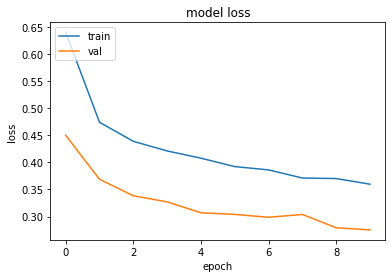

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

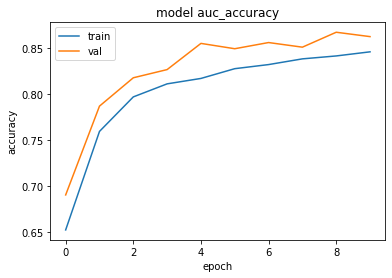

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model auc_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [11]:
val_df = pd.read_csv('../input/cq500-normal-images-and-labels/NormalAbnormal/NormalAbnormal/Validation_f1.csv')
abnormal = val_df.loc[val_df['Abnormal']==1]
normal = val_df.loc[val_df['Normal']==1]
normal=shuffle(normal)
normal = normal.iloc[0:len(abnormal)]
val_df = abnormal.append(normal, ignore_index=True)
val_df = shuffle(val_df)
print(len(val_df))

HEIGHT = 256
WIDTH = 256
CHANNELS = 3
VALID_BATCH_SIZE = 64
SHAPE = (HEIGHT, WIDTH, CHANNELS)

class_names = ['Normal', 'Abnormal']
data_generator_test = TrainDataGenerator(val_df,
                                        class_names, 
                                        VALID_BATCH_SIZE, 
                                        SHAPE,
                                        augment = False,
                                        shuffle = False
                                        )

y_true = val_df[class_names].values
y_hat = model.predict(data_generator_test, verbose=1)

y_hat = y_hat[0:len(y_true)]
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_true, axis=1)

51144
800/800 [==============================] - 724s 905ms/step


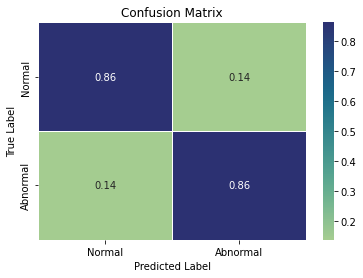

In [12]:
print_confusion_matrix(y_true, y_pred, class_names)

In [13]:
print_performance_metrics(y_true, y_pred, class_names)

Accuracy: 0.8594
Precision: 0.8594
Recall: 0.8594
F1 Score: 0.8594
Cohen Kappa Score: 0.7187
Matthews Corrcoef: 0.7187
ROC AUC: 0.8593578914437666
		Classification Report:
               precision    recall  f1-score   support

      Normal       0.86      0.86      0.86     25572
    Abnormal       0.86      0.86      0.86     25572

    accuracy                           0.86     51144
   macro avg       0.86      0.86      0.86     51144
weighted avg       0.86      0.86      0.86     51144



In [14]:
val_df = pd.read_csv('../input/cq500-normal-images-and-labels/NormalAbnormal/NormalAbnormal/RSNA/Validation_f0.csv')
abnormal = val_df.loc[val_df['Abnormal']==1]
normal = val_df.loc[val_df['Normal']==1]
normal=shuffle(normal)
normal = normal.iloc[0:len(abnormal)]
val_df = abnormal.append(normal, ignore_index=True)
val_df = shuffle(val_df)
print(len(val_df))

HEIGHT = 256
WIDTH = 256
CHANNELS = 3
VALID_BATCH_SIZE = 64
SHAPE = (HEIGHT, WIDTH, CHANNELS)

class_names = ['Normal', 'Abnormal']
data_generator_test = TrainDataGenerator(val_df,
                                        class_names, 
                                        VALID_BATCH_SIZE, 
                                        SHAPE,
                                        augment = False,
                                        shuffle = False
                                        )

y_true = val_df[class_names].values
y_hat = model.predict(data_generator_test, verbose=1)

y_hat = y_hat[0:len(y_true)]
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_true, axis=1)

42770
669/669 [==============================] - 532s 795ms/step


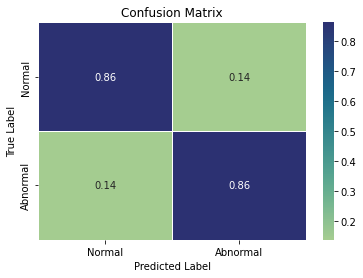

In [15]:
print_confusion_matrix(y_true, y_pred, class_names)

In [16]:
print_performance_metrics(y_true, y_pred, class_names)

Accuracy: 0.8598
Precision: 0.8598
Recall: 0.8598
F1 Score: 0.8598
Cohen Kappa Score: 0.7196
Matthews Corrcoef: 0.7196
ROC AUC: 0.8598082768295534
		Classification Report:
               precision    recall  f1-score   support

      Normal       0.86      0.86      0.86     21385
    Abnormal       0.86      0.86      0.86     21385

    accuracy                           0.86     42770
   macro avg       0.86      0.86      0.86     42770
weighted avg       0.86      0.86      0.86     42770



In [17]:
val_df = pd.read_csv('../input/cq500-normal-images-and-labels/NormalAbnormal/NormalAbnormal/CQ500/Validation_f0.csv')
abnormal = val_df.loc[val_df['Abnormal']==1]
normal = val_df.loc[val_df['Normal']==1]
normal=shuffle(normal)
normal = normal.iloc[0:len(abnormal)]
val_df = abnormal.append(normal, ignore_index=True)
val_df = shuffle(val_df)
print(len(val_df))

HEIGHT = 256
WIDTH = 256
CHANNELS = 3
VALID_BATCH_SIZE = 64
SHAPE = (HEIGHT, WIDTH, CHANNELS)

class_names = ['Normal', 'Abnormal']
data_generator_test = TrainDataGenerator(val_df,
                                        class_names, 
                                        VALID_BATCH_SIZE, 
                                        SHAPE,
                                        augment = False,
                                        shuffle = False
                                        )

y_true = val_df[class_names].values
y_hat = model.predict(data_generator_test, verbose=1)

y_hat = y_hat[0:len(y_true)]
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_true, axis=1)

8374
131/131 [==============================] - 85s 649ms/step


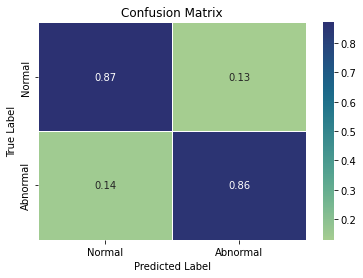

In [18]:
print_confusion_matrix(y_true, y_pred, class_names)

In [19]:
print_performance_metrics(y_true, y_pred, class_names)

Accuracy: 0.8636
Precision: 0.8637
Recall: 0.8636
F1 Score: 0.8636
Cohen Kappa Score: 0.7273
Matthews Corrcoef: 0.7273
ROC AUC: 0.8636255075232864
		Classification Report:
               precision    recall  f1-score   support

      Normal       0.86      0.87      0.86      4187
    Abnormal       0.87      0.86      0.86      4187

    accuracy                           0.86      8374
   macro avg       0.86      0.86      0.86      8374
weighted avg       0.86      0.86      0.86      8374

